In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
from tqdm import tqdm
import random

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torchvision

import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

In [25]:
AUDIO_DATA_PATH_ROOT = '/home/therock/data2/GTZAN_audio/archive/Data/genres_original'
audio_sample_metal = AUDIO_DATA_PATH_ROOT + '/metal/metal.00024.wav'
audio_sample_metal_data , audio_sample_metal_sr = librosa.load(audio_sample_metal)

audio_sample_blues = AUDIO_DATA_PATH_ROOT + '/blues/blues.00024.wav'
audio_sample_blues_data , audio_sample_blues_sr = librosa.load(audio_sample_blues)

In [26]:
ipd.Audio(audio_sample_metal)

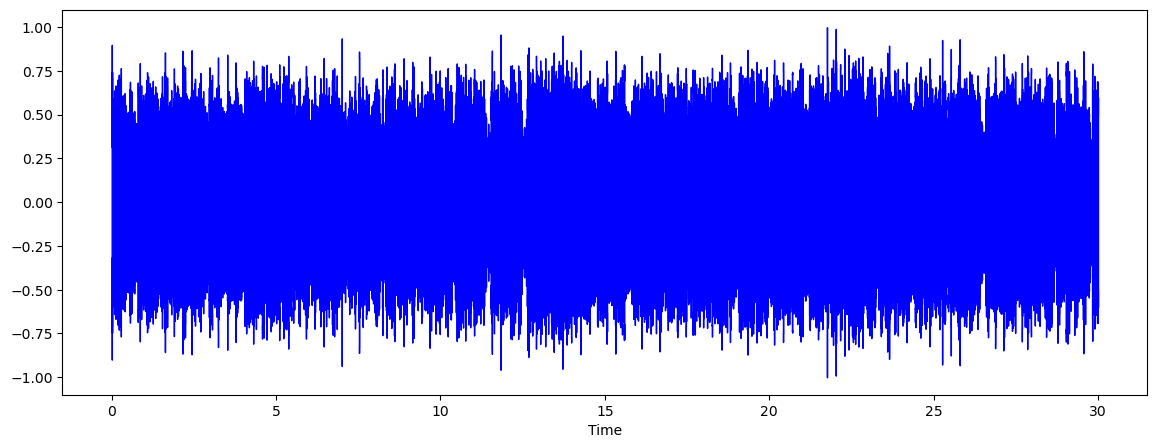

In [27]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_sample_metal_data, sr=audio_sample_metal_sr,color="blue")
plt.show()

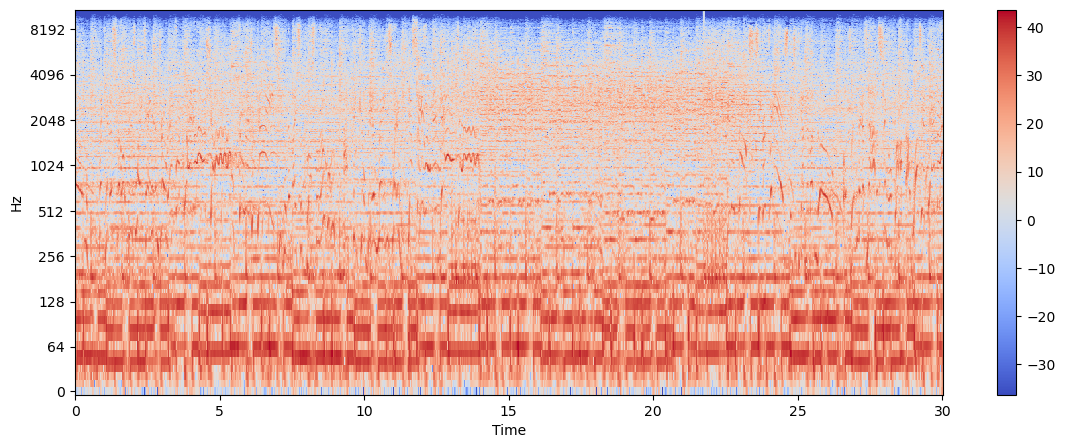

In [28]:
#display Spectrogram
X = librosa.stft(audio_sample_metal_data)
plt.figure(figsize=(14, 5))
# log of frequencies  
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=audio_sample_metal_sr, x_axis='time', y_axis='log')
plt.colorbar()

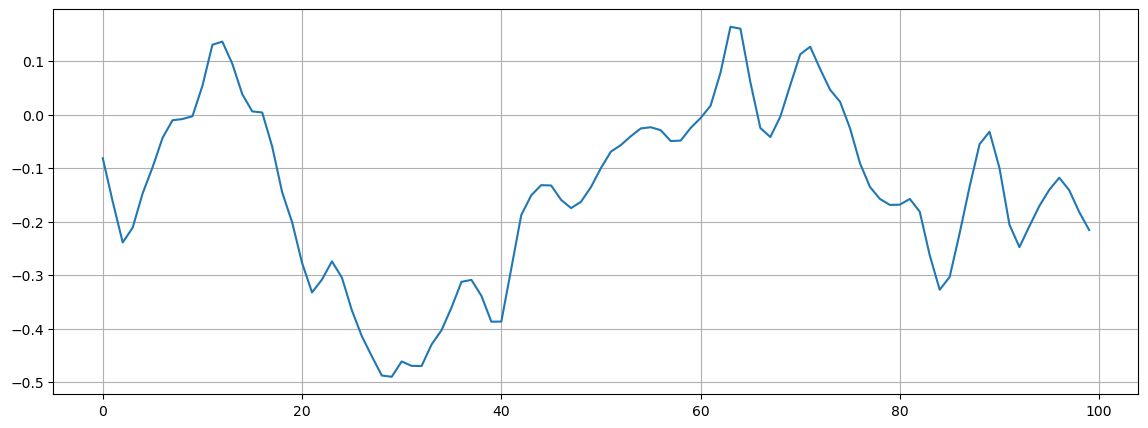

In [29]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(audio_sample_metal_data[n0:n1])
plt.grid()

In [30]:
zero_crossings = librosa.zero_crossings(audio_sample_metal_data[n0:n1], pad=False)
print(sum(zero_crossings))

6


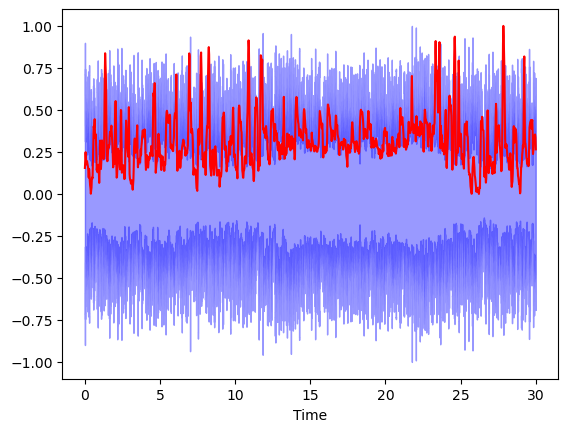

In [31]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound

spectral_centroids = librosa.feature.spectral_centroid(y=audio_sample_metal_data, sr=audio_sample_metal_sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(audio_sample_metal_data, sr=audio_sample_metal_sr, alpha=0.4, color='blue')
plt.plot(t, normalize(spectral_centroids), color='r')

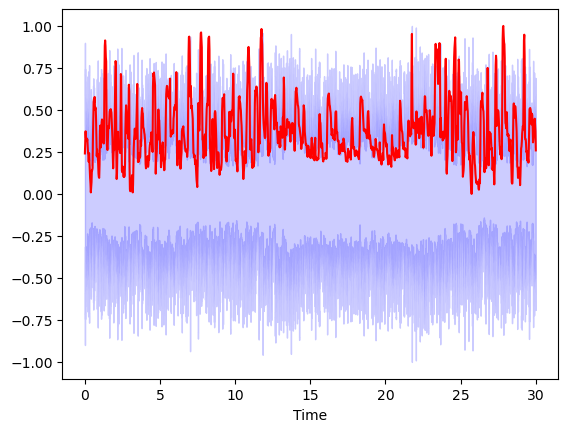

In [32]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_sample_metal_data, sr=audio_sample_metal_sr)[0]
librosa.display.waveshow(audio_sample_metal_data, sr=audio_sample_metal_sr, alpha=0.2, color='blue')
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 1293)


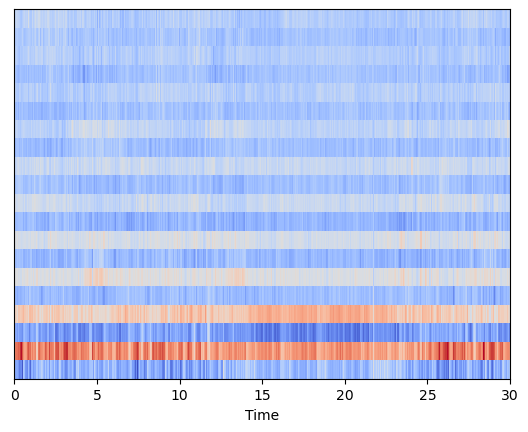

In [33]:
mfccs = librosa.feature.mfcc(y=audio_sample_metal_data, sr=audio_sample_metal_sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=audio_sample_metal_sr, x_axis='time')

[Text(0.5, 1.0, 'Mel-frequency spectrogram Metal')]

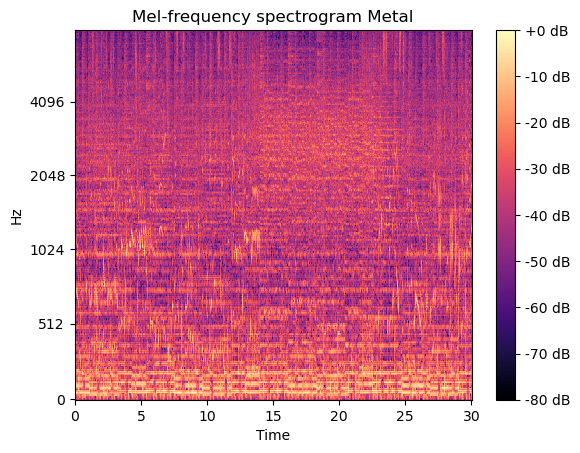

In [34]:
fig, ax = plt.subplots()
S = librosa.feature.melspectrogram(y=audio_sample_metal_data, sr=audio_sample_metal_sr, n_mels=512,
                                    fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=audio_sample_metal_sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram Metal')

[Text(0.5, 1.0, 'Mel-frequency spectrogram Blues')]

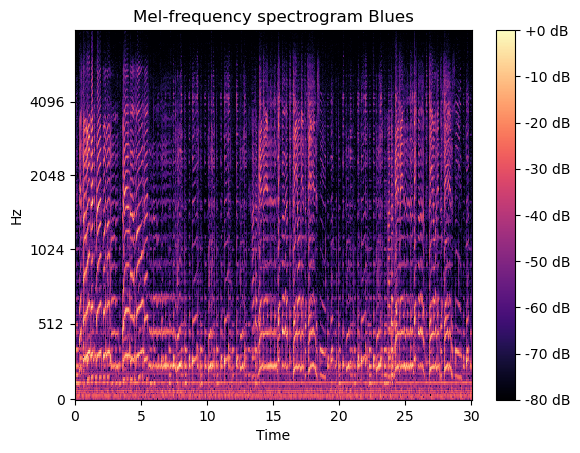

In [35]:
fig, ax = plt.subplots()
S = librosa.feature.melspectrogram(y=audio_sample_blues_data, sr=audio_sample_blues_sr, n_mels=512,
                                    fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=audio_sample_metal_sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram Blues')

# Extract audio features using Librosa

In [37]:
AUDIO_FEATURES_CSV_FILE = 'audio_features_data.csv'

In [21]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open(AUDIO_FEATURES_CSV_FILE, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'{audio_path_root}/{g}'):
        songname = f'{audio_path_root}/{g}/{filename}'
        try:
            y, sr = librosa.load(songname, mono=True, duration=30)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)[0]
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {g}'
            file = open(AUDIO_FEATURES_CSV_FILE, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())
        except:
            print(f"Skipping {songname}")

/tmp/ipykernel_33186/3852855751.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(songname, mono=True, duration=30)
/home/therock/anaconda3/envs/conda_torch/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping /home/therock/data2/GTZAN_audio/archive/Data/genres_original/jazz/jazz.00054.wav


In [38]:
audio_df_all = pd.read_csv(AUDIO_FEATURES_CSV_FILE)
audio_df = audio_df_all.drop(['filename'],axis=1)
audio_df.head()

chroma_stft      rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.339061  0.098878        1443.268862         1670.239575  3069.306440   
1     0.390160  0.136178        2279.265543         2375.084795  5198.476899   
2     0.288250  0.173309        1507.104729         2096.717628  3405.412741   
3     0.265896  0.168086        1513.520053         2140.702824  3449.845806   
4     0.342027  0.259655        2094.775834         2158.105747  4482.256230   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.067194 -225.300308  117.641518 -14.544604  64.802383  ...   
1            0.092570 -109.532349   86.926498  -8.624988  64.489502  ...   
2            0.045430 -171.810196  120.280624  15.327538  21.090450  ...   
3            0.044378 -192.693832  111.188164  21.373314  26.392143  ...   
4            0.100570  -30.129288  103.744797 -19.765732  56.411625  ...   

      mfcc12     mfcc13    mfcc14     mfcc15     mfcc16     mfcc17    mfcc18  \
0   3.049367  -7.628483 -8.961093  -4.351271  -0.065285  -2.553241 -3.436928   
1  11.086615  -5.094466  3.978770 -12.864775  12.342426   0.020587 -0.739240   
2  -4.988853 -17.118925 -7.886534 -15.308929  -9.351315  -8.913866 -8.525090   
3  -5.045355 -17.632242 -7.920870 -15.150279 -12.345929 -17.235107 -7.781935   
4  11.210426  -8.851257  9.101229  -3.574045   4.384885  -2.830827  4.726116   

      mfcc19     mfcc20  label  
0  -3.867452   1.317023  blues  
1  -5.130450   3.307130  blues  
2 -14.333636 -19.933725  blues  
3 -13.042010 -17.948874  blues  
4   0.482424   1.477394  blues  

[5 rows x 27 columns]

## Label Encoding and features Scalling

In [39]:
genre_list = audio_df['label']
genre_encoder = LabelEncoder()
audio_df['label'] = genre_encoder.fit_transform(genre_list)
audio_df.head()

chroma_stft      rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.339061  0.098878        1443.268862         1670.239575  3069.306440   
1     0.390160  0.136178        2279.265543         2375.084795  5198.476899   
2     0.288250  0.173309        1507.104729         2096.717628  3405.412741   
3     0.265896  0.168086        1513.520053         2140.702824  3449.845806   
4     0.342027  0.259655        2094.775834         2158.105747  4482.256230   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.067194 -225.300308  117.641518 -14.544604  64.802383  ...   
1            0.092570 -109.532349   86.926498  -8.624988  64.489502  ...   
2            0.045430 -171.810196  120.280624  15.327538  21.090450  ...   
3            0.044378 -192.693832  111.188164  21.373314  26.392143  ...   
4            0.100570  -30.129288  103.744797 -19.765732  56.411625  ...   

      mfcc12     mfcc13    mfcc14     mfcc15     mfcc16     mfcc17    mfcc18  \
0   3.049367  -7.628483 -8.961093  -4.351271  -0.065285  -2.553241 -3.436928   
1  11.086615  -5.094466  3.978770 -12.864775  12.342426   0.020587 -0.739240   
2  -4.988853 -17.118925 -7.886534 -15.308929  -9.351315  -8.913866 -8.525090   
3  -5.045355 -17.632242 -7.920870 -15.150279 -12.345929 -17.235107 -7.781935   
4  11.210426  -8.851257  9.101229  -3.574045   4.384885  -2.830827  4.726116   

      mfcc19     mfcc20  label  
0  -3.867452   1.317023      0  
1  -5.130450   3.307130      0  
2 -14.333636 -19.933725      0  
3 -13.042010 -17.948874      0  
4   0.482424   1.477394      0  

[5 rows x 27 columns]

In [40]:
audio_df_x = audio_df.drop(['label'],axis=1)
audio_df_y = audio_df['label']

scaler = StandardScaler()
cols = list(audio_df_x.columns)
audio_df_x[cols] = scaler.fit_transform(audio_df_x[cols])

audio_df_x = torch.tensor(audio_df_x.values, dtype=torch.float32)
audio_df_y = torch.tensor(audio_df_y.values, dtype=torch.long)

In [41]:
total_sample_size = (len(audio_df_y))
test_sample_size = 0.10 
valid_sample_size = 0.20

x_train, x_test, y_train, y_test = train_test_split(audio_df_x, audio_df_y, test_size=test_sample_size, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_sample_size, shuffle=True)

if total_sample_size == (len(x_train) + len(x_valid) + len(x_test)):
    print(f"train_data = {len(x_train)}, valid_data = {len(x_valid)}, test_data = {len(x_test)}")
else:
    print("error in splitting data correctly\n")

train_data = 719, valid_data = 180, test_data = 100


# ANN based model

In [31]:
class MusicGenreModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 64)
        self.linear2 = nn.Linear(64, 1280)
        self.linear3 = nn.Linear(1280, 32)
        self.linear4 = nn.Linear(32, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.10)

    def forward(self, x):
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))
        x = self.dropout(self.relu(self.linear4(x)))

        return x

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [33]:
in_features = len(cols)
out_features = len(genre_encoder.classes_)
model = MusicGenreModel(in_features, out_features).to(device)
print(model)

MusicGenreModel(
  (linear1): Linear(in_features=26, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1280, bias=True)
  (linear3): Linear(in_features=1280, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [35]:
learning_rate = 0.003
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Model Training

In [43]:
epoch_count, train_acc_values, train_loss_values, valid_loss_values, valid_acc_values = [], [], [], [], []

epochs = 100
x_train = x_train.to(device)
y_train = y_train.to(device)

x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):

    model.train()
    
    y_logits = model(x_train).squeeze()
    y_pred = torch.max(y_logits.data, 1)[1]

    loss = loss_fn(y_logits, y_train)  # compute the loss
    acc = (y_pred == y_train).sum().item() / len(y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        valid_logits = model(x_valid).squeeze()
        valid_pred = torch.max(valid_logits.data, 1)[1]
        valid_loss = loss_fn(valid_logits, y_valid)
        valid_acc = (valid_pred == y_valid).sum().item() / len(y_valid)

    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss.cpu().detach().numpy()}, Accuracy: {acc:.2f}% |" Validation Loss: {valid_loss.cpu().detach().numpy()}, Accuracy: {valid_acc:.2f}%')


    epoch_count.append(epoch)
    train_loss_values.append(loss.cpu().detach().numpy())
    train_acc_values.append(acc)
    valid_acc_values.append(valid_acc)
    valid_loss_values.append(valid_loss.cpu().detach().numpy())


Epoch:    0 | Train Loss: 1.8622666597366333, Accuracy: 0.37% |" Validation Loss: 1.6870486736297607, Accuracy: 0.47%
Epoch:    5 | Train Loss: 1.527915596961975, Accuracy: 0.48% |" Validation Loss: 1.5057169198989868, Accuracy: 0.48%
Epoch:   10 | Train Loss: 1.4486072063446045, Accuracy: 0.56% |" Validation Loss: 1.4383610486984253, Accuracy: 0.52%
Epoch:   15 | Train Loss: 1.2911994457244873, Accuracy: 0.59% |" Validation Loss: 1.3714289665222168, Accuracy: 0.56%
Epoch:   20 | Train Loss: 1.2189078330993652, Accuracy: 0.62% |" Validation Loss: 1.2967630624771118, Accuracy: 0.57%
Epoch:   25 | Train Loss: 1.1072124242782593, Accuracy: 0.65% |" Validation Loss: 1.2892591953277588, Accuracy: 0.59%
Epoch:   30 | Train Loss: 1.0737719535827637, Accuracy: 0.66% |" Validation Loss: 1.2516157627105713, Accuracy: 0.59%
Epoch:   35 | Train Loss: 0.9660242199897766, Accuracy: 0.69% |" Validation Loss: 1.2393852472305298, Accuracy: 0.61%
Epoch:   40 | Train Loss: 0.9669066071510315, Accuracy: 0

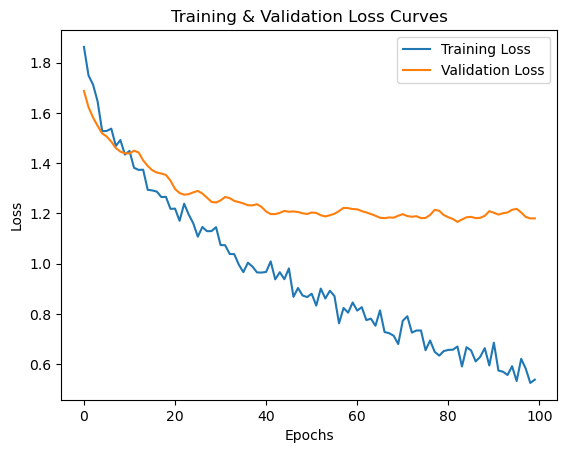

In [45]:
plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

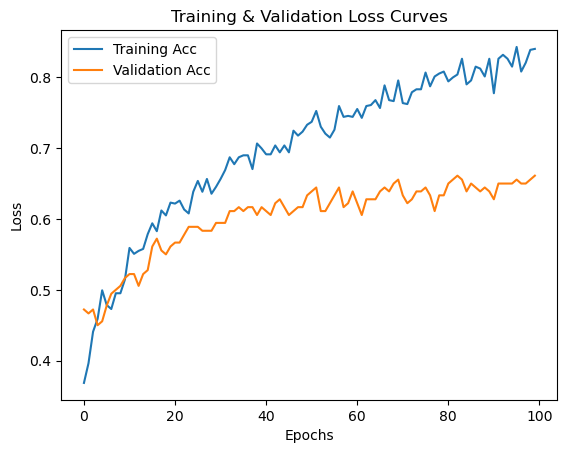

In [46]:
plt.plot(epoch_count, train_acc_values, label='Training Acc')
plt.plot(epoch_count, valid_acc_values, label='Validation Acc')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Testing the model

In [48]:
model.eval()

x_test = x_test.cpu()
y_test = y_test.cpu()

with torch.inference_mode():
    test_logits = model(x_test).squeeze()
    test_pred = torch.max(test_logits.data, 1)[1]
    acc = (test_pred == y_test).sum().item() / len(y_test)

print(f"Test accuracy = {acc}")

Test accuracy = 0.64


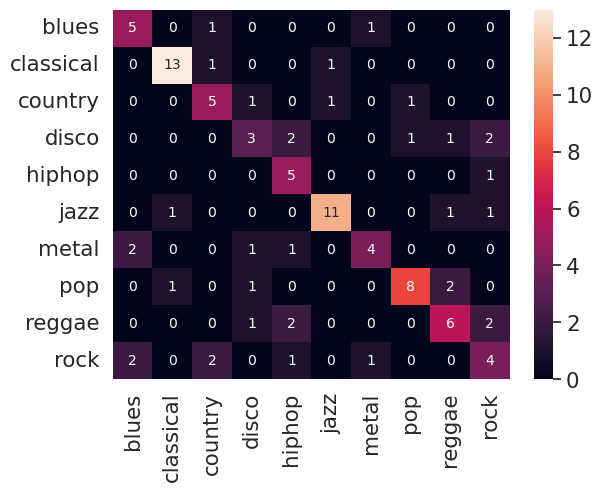

In [52]:
y_test = y_test.cpu()
test_pred = test_pred.cpu()

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, test_pred)
genre_classes_len = len(genre_encoder.classes_)
df_cm = pd.DataFrame(confusion_matrix, genre_encoder.classes_, genre_encoder.classes_)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()

# Feature extraction for CNN based model

In [2]:
MEL_SPECT_IMG_ROOT = '/home/therock/data2/GTZAN_melspect_img'

In [7]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
gbar = tqdm(range(len(genres)))
for i in gbar:
    g = genres[i]
    gbar.set_description(f"processing {g}")
    music_filenames = os.listdir(f'{AUDIO_DATA_PATH_ROOT}/{g}')
    fbar = range(len(music_filenames))
    for f in fbar:
        filename = music_filenames[f]
        songname = f'{AUDIO_DATA_PATH_ROOT}/{g}/{filename}'
        melspect_img_dir = f'{MEL_SPECT_IMG_ROOT}/{g}'
        melspect_img_path = melspect_img_dir + '/' + filename[:-3] + 'png'
        os.makedirs(melspect_img_dir, exist_ok=True)
        #print(f'{songname} coverted to {melspect_img_path}')

        try:
            audio_data , audio_sr = librosa.load(songname)
            S = librosa.feature.melspectrogram(y=audio_data, sr=audio_sr, n_mels=512, fmax=8000)
            S_dB = librosa.power_to_db(S, ref=np.max)
            plt.imsave(melspect_img_path, S_dB)
        except:
            print(f"failed to process {songname}")

processing jazz:  50%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 5/10 [02:38<02:40, 32.17s/it]/tmp/ipykernel_86049/3560954206.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data , audio_sr = librosa.load(songname)
/home/therock/anaconda3/envs/conda_torch/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


failed to process /home/therock/data2/GTZAN_audio/archive/Data/genres_original/jazz/jazz.00054.wav


processing rock: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:17<00:00, 31.76s/it]


In [9]:
train_split = 0.80
valid_split = 0.10
test_split = 0.10
batch_size = 8
workers_count = 8
image_dim_x = 128
image_dim_y = 1280

transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((image_dim_x, image_dim_y)),
            torchvision.transforms.ToTensor()
        ])
dataset = torchvision.datasets.ImageFolder(MEL_SPECT_IMG_ROOT, transform=transform)
dataset_len = len(dataset)
indices = list(range(dataset_len))
random.shuffle(indices)
train_end = int(np.floor(train_split * dataset_len))
valid_end = int(np.floor(valid_split * dataset_len))
test_end = int(np.floor(test_split * dataset_len))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(indices[:train_end]),
                                           num_workers=workers_count)

valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.sampler.SubsetRandomSampler(
                                             indices[train_end:train_end+valid_end]),
                                         num_workers=workers_count)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.sampler.SubsetRandomSampler(
                                             indices[train_end+valid_end:dataset_len]),
                                         num_workers=workers_count)

train_set_len = len(train_loader)# * batch_size
val_set_len = len(valid_loader)# * batch_size
test_set_len = len(test_loader)# * batch_size
class_names = dataset.classes
num_of_classes = len(dataset.classes)

In [11]:
# utility function to calculate o/p dim of conv layer
def conv_out_calc(in_size, filter, padding, stride):
    return ((in_size - filter + 2 * padding) // stride ) + 1

# CNN based model


In [12]:
class CNNMusic_Genre_Model1(nn.Module):
    def __init__(self, image_dim_x=32, image_dim_y=32, num_of_classes=10):
        super().__init__()

        self.image_dim_x = image_dim_x
        self.image_dim_y = image_dim_y
        self.num_of_classes = num_of_classes

        self.conv1_out_channel = 8
        self.conv1_kernel_size = 3

        self.conv2_out_channel = 64
        self.conv2_kernel_size = 3

        self.conv3_out_channel = 128
        self.conv3_kernel_size = 3

        
        self.linear1_out_features = 1024
        self.linear2_out_features = 128

        self.conv1 = nn.Conv2d(3, self.conv1_out_channel, self.conv1_kernel_size, stride=1,
                               padding=(2, 2))
        self.conv1_out_x = conv_out_calc(self.image_dim_x, self.conv1_kernel_size, 2, 1) //2 
        self.conv1_out_y = conv_out_calc(self.image_dim_y, self.conv1_kernel_size, 2, 1) //2

        self.bn1 = nn.BatchNorm2d(self.conv1_out_channel)

        self.conv2 = nn.Conv2d(self.conv1_out_channel, self.conv2_out_channel, self.conv2_kernel_size, stride=1,
                               padding=(2, 2))
        self.conv2_out_x = conv_out_calc(self.conv1_out_x, self.conv2_kernel_size, 2, 1) //2
        self.conv2_out_y = conv_out_calc(self.conv1_out_y, self.conv2_kernel_size, 2, 1) //2
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channel)

        self.conv3 = nn.Conv2d(self.conv2_out_channel, self.conv3_out_channel, self.conv3_kernel_size, stride=1,
                               padding=(2, 2))
        self.conv3_out_x = conv_out_calc(self.conv2_out_x, self.conv3_kernel_size, 2, 1) //2
        self.conv3_out_y = conv_out_calc(self.conv2_out_y, self.conv3_kernel_size, 2, 1) //2
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channel)
        
        self.fc_dim = self.conv3_out_x * self.conv3_out_y * self.conv3_out_channel

        self.fc1 = nn.Linear(self.fc_dim, self.linear1_out_features)
        self.fc2 = nn.Linear(self.linear1_out_features, self.linear2_out_features)
        self.fc3 = nn.Linear(self.linear2_out_features, self.num_of_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.bn1(X)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.bn2(X)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.bn3(X)
        X = X.view(-1, self.fc_dim)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = nn.CrossEntropyLoss().to(device)
epochs = 20
lr = 0.0001


In [14]:
model =  CNNMusic_Genre_Model1(image_dim_x=image_dim_x, image_dim_y=image_dim_y, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
train_accuracy = []

valid_losses = []
valid_accuracy = []


tqdm_train_descr_format = "Training CNN model: Epoch Accuracy = {:02.4f}%, Loss = {:.8f} | Mean Accuracy = {:02.4f}%"
tqdm_train_descr = tqdm_train_descr_format.format(0, float('inf'),0)
tqdm_train_obj = tqdm(range(epochs), desc=tqdm_train_descr)

for i in tqdm_train_obj:

        train_epoch_corr = 0
        train_epoch_loss = 0
        total_train_samples = 0

        valid_epoch_corr = 0
        valid_epoch_loss = 0
        total_valid_samples = 0

        model.train()
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(X_train)
            train_loss = criterion(y_pred, y_train)

            train_predicted = torch.max(y_pred.data, 1)[1]
            
            train_batch_corr = (train_predicted == y_train).sum()
            train_epoch_corr += train_batch_corr.item()
            train_epoch_loss += train_loss.item()
            
            total_train_samples += y_pred.shape[0]

            # Update parameters
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
        
                valid_predictions = model(X_valid)
                valid_loss = criterion(valid_predictions, y_valid)
        
                valid_predicted = torch.max(valid_predictions.data, 1)[1]
                
                valid_batch_corr = (valid_predicted == y_valid).sum()
                valid_epoch_corr += valid_batch_corr.item()
                valid_epoch_loss += valid_loss.item()

                total_valid_samples += y_valid.shape[0]
              
       
        train_epoch_accuracy = train_epoch_corr * 100 / total_train_samples
        train_epoch_loss = train_epoch_loss / total_train_samples

        train_losses.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        valid_epoch_accuracy = valid_epoch_corr * 100 / total_valid_samples
        valid_epoch_loss = valid_epoch_loss / total_valid_samples

        valid_losses.append(valid_epoch_loss)
        valid_accuracy.append(valid_epoch_accuracy)

        tqdm_descr = tqdm_train_descr_format.format(train_epoch_accuracy, train_epoch_loss, np.mean(train_accuracy))
        tqdm_train_obj.set_description(tqdm_descr)


Training CNN model: Epoch Accuracy = 99.8748%, Loss = 0.00191925 | Mean Accuracy = 95.8448%: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.83s/it]


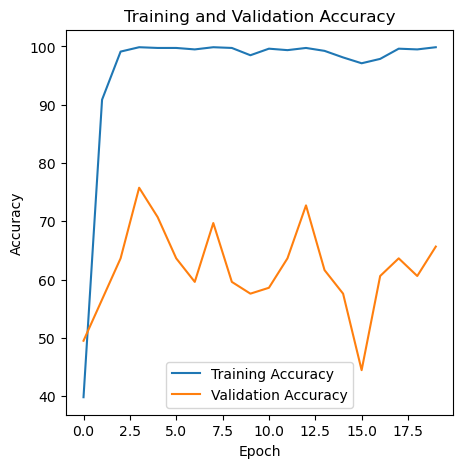

In [19]:
model_accuracy_png = 'training_validation_acc.png'

fig = plt.figure(figsize=(5, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig(model_accuracy_png)
plt.show()
plt.close(fig)

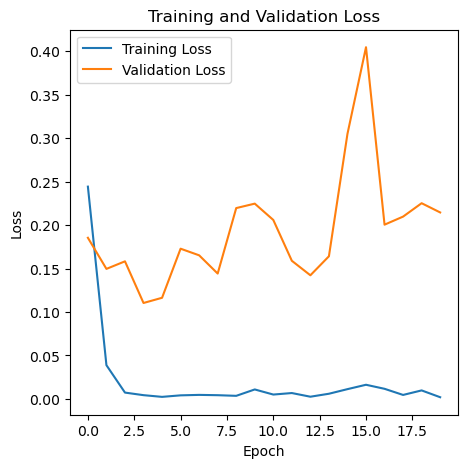

In [20]:
model_loss_png = 'training_validation_loss.png'

fig = plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(model_loss_png)
plt.show()
plt.close(fig)

In [17]:
tqdm_test_descr_format = "Testing CNN model: Batch Accuracy = {:02.4f}%"
tqdm_test_descr = tqdm_test_descr_format.format(0)
tqdm_test_obj = tqdm(test_loader, desc=tqdm_test_descr)
num_of_batches = len(test_loader)

model.eval()

total_test_loss = 0
total_test_acc = 0
predicted_all = torch.tensor([], dtype=torch.long, device=device)
ground_truth_all = torch.tensor([], dtype=torch.long, device=device)

with torch.no_grad():
    for b, (X_test, y_test) in enumerate(tqdm_test_obj):
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        predictions = model(X_test)
        loss = criterion(predictions, y_test)

        predicted = torch.max(predictions.data, 1)[1]
        batch_corr = (predicted == y_test).sum()
        batch_acc = batch_corr.item() * 100 / predictions.shape[0]
        total_test_acc += batch_acc
        total_test_loss += loss.item()

        predicted_all = torch.cat((predicted_all, predicted), 0)
        ground_truth_all = torch.cat((ground_truth_all, y_test), 0)

        tqdm_test_descr = tqdm_test_descr_format.format(batch_acc)
        tqdm_test_obj.set_description(tqdm_test_descr)

predicted_all = predicted_all.cpu().numpy()
ground_truth_all = ground_truth_all.cpu().numpy()
total_test_acc = total_test_acc / num_of_batches

Testing CNN model: Batch Accuracy = 20.0000%: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 12.96it/s]


In [21]:
print(f"Test accuracy = {total_test_acc:0.2f}%")

Test accuracy = 71.73%


In [43]:
y_test = y_test.cpu()
predicted = predicted_all.cpu()

In [44]:
y_test.shape

torch.Size([100])

In [45]:
predicted.shape

torch.Size([5])

In [42]:
y_test = y_test.cpu()
predicted = predicted.cpu()

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predicted)
genre_classes_len = len(genre_encoder.classes_)
df_cm = pd.DataFrame(confusion_matrix, genre_encoder.classes_, genre_encoder.classes_)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [100, 5]